In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

In [3]:
cincinnati = pd.read_csv('cincinnati_data.csv').set_index('DATE').fillna(method='ffill')
baltimore = pd.read_csv('baltimore_data.csv').set_index('DATE').fillna(method='ffill')
richmond = pd.read_csv('richmond_data.csv').set_index('DATE').fillna(method='ffill')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (3,30,31,32,41,42,43,44,49,51,58,69,71,72,88,95,96,97,98,99,100,101,102,103,104,105,106,107) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (30,31,33,34,41,42,43,49,51,69,71,75,76,88,89) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (30,31,33,34,35,36,41,42,43,48,49,51,53,56,58,59,69,71,73,75,76,88,89) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
cincinnati.index = pd.to_datetime(cincinnati.index).round('h')
baltimore.index = pd.to_datetime(baltimore.index).round('h')
richmond.index = pd.to_datetime(richmond.index).round('h')

In [5]:
columns = []
for i in cincinnati.columns:
    if 'Hourly' in i:
        columns.append(i)

In [6]:
cincinnati = cincinnati[columns]
baltimore = baltimore[columns]
richmond = richmond[columns]

In [7]:
columns.remove('HourlySkyConditions')
columns.remove('HourlyPresentWeatherType')
columns.remove('HourlyPrecipitation')

In [8]:
for col in columns:
    for i in enumerate(cincinnati[col]):
        if type(i[1]) == int or type(i[1]) == float:
            pass
        elif 's' in i[1]:
            cincinnati[col][cincinnati[col]==i[1]] = float(i[1][:-1])
            
for col in columns:
    for i in enumerate(baltimore[col]):
        if type(i[1]) == int or type(i[1]) == float:
            pass
        elif 's' in i[1]:
            baltimore[col][baltimore[col]==i[1]] = float(i[1][:-1])
            
for col in columns:
    for i in enumerate(richmond[col]):
        if type(i[1]) == int or type(i[1]) == float:
            pass
        elif 's' in i[1]:
            richmond[col][richmond[col]==i[1]] = float(i[1][:-1])

<ipython-input-8-917036c01284>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cincinnati[col][cincinnati[col]==i[1]] = float(i[1][:-1])
<ipython-input-8-917036c01284>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baltimore[col][baltimore[col]==i[1]] = float(i[1][:-1])
<ipython-input-8-917036c01284>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  richmond[col][richmond[col]==i[1]] = float(i[1][:-1])


# EV Data

In [9]:
ev = pd.read_excel('Solar_GenX.xlsx').set_index('datetime_beginning_ept').fillna(method='bfill')
ev.index = pd.to_datetime(ev.index)

# Cincinnati

In [10]:
df = pd.merge(ev['WEST_solar'], cincinnati, left_index=True, right_index=True)

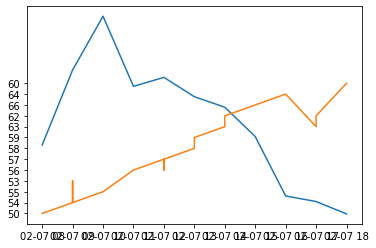

In [11]:
plt.plot(df.index[1390:1420], df['WEST_solar'][1390:1420])
plt.plot(df.index[1390:1420], df['HourlyDryBulbTemperature'][1390:1420])

In [12]:
conds = []

for val in df['HourlySkyConditions'].unique():
    if type(val) != float and type(val) != np.nan:
        if val[:3] not in conds:
            conds.append(val[:3])

In [13]:
conds

['FEW', 'OVC', 'BKN', 'SCT', 'CLR', 'VV:', '3', '2']

In [15]:
for col in df.columns:
    df[col] = (pd.to_numeric(df[col], errors='coerce').fillna(0))

In [46]:
X = df.drop(['WEST_solar', 'HourlyPresentWeatherType', 'HourlySkyConditions'], axis=1)
y = df['WEST_solar']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [47]:
tree = RandomForestRegressor()
tree.fit(X_train,y_train)
score_tree = tree.score(X_test,y_test)
tree_predict = tree.predict(X_test)

In [48]:
r2_score(y_test, tree_predict)

0.6503039395027275

In [49]:
y_pred = tree.predict(X)

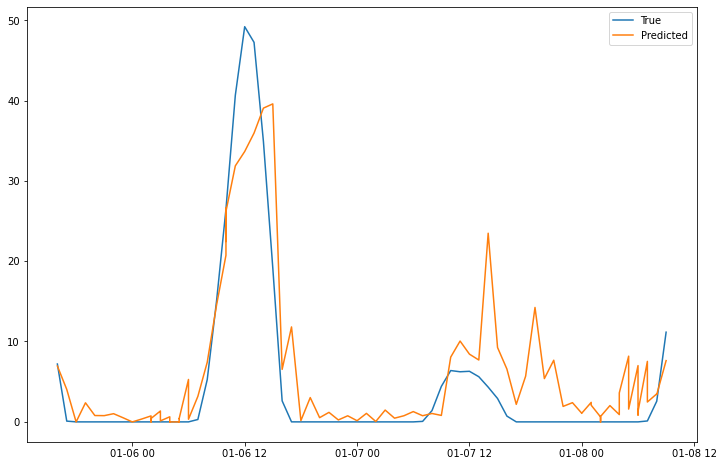

In [50]:
plt.figure(figsize=(12, 8))
plt.plot(df.index[150:250], df['WEST_solar'][150:250], label = 'True')
plt.plot(df.index[150:250], y_pred[150:250], label = 'Predicted')
plt.legend()

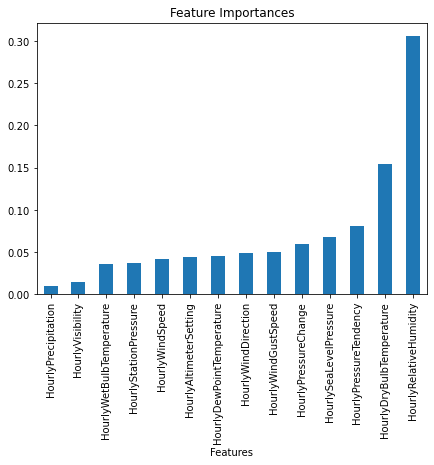

In [51]:
feature_importance_df = pd.DataFrame({'Feature Importances': tree.feature_importances_, 'Features': X_train.columns.values})

feature_importance_df.sort_values('Feature Importances').plot.bar(x = 'Features', figsize = (7, 5), legend=False, title='Feature Importances');

In [52]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X, y)
y_pred = lm.predict(X)

In [53]:
r2_score(y, y_pred)

0.3898969898836231

In [54]:
coefs = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(lm.coef_), columns = ['EV Generation'])], axis = 1)
coefs = coefs.set_index(0)

In [55]:
coefs.sort_values('EV Generation', ascending = False)

,EV Generation
0,
HourlySeaLevelPressure,141.506271
HourlyPrecipitation,19.335737
HourlyDryBulbTemperature,2.359248
HourlyPressureChange,0.823797
HourlyDewPointTemperature,0.535342
HourlyWindSpeed,0.450570
HourlyWindDirection,-0.005726
HourlyPressureTendency,-0.078394
HourlyWindGustSpeed,-0.138841


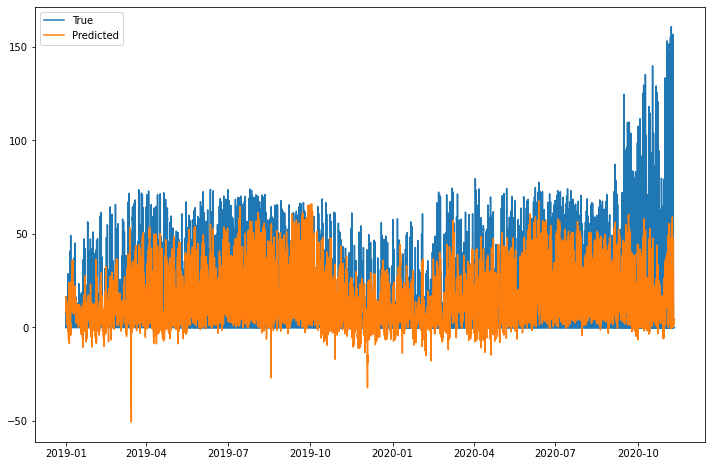

In [56]:
plt.figure(figsize=(12, 8))
plt.plot(df.index[0:100], df['WEST_solar'][0:100], label = 'True')
plt.plot(df.index[0:100], y_pred[0:100], label = 'Predicted')
plt.legend()

# Richmond

In [28]:
df2 = pd.merge(ev['SOUTH_solar'], richmond, left_index=True, right_index=True)

In [30]:
df2.columns.drop(['HourlyPresentWeatherType', 'HourlySkyConditions'])

Index(['SOUTH_solar', 'HourlyAltimeterSetting', 'HourlyDewPointTemperature',
       'HourlyDryBulbTemperature', 'HourlyPrecipitation',
       'HourlyPressureChange', 'HourlyPressureTendency',
       'HourlyRelativeHumidity', 'HourlySeaLevelPressure',
       'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature',
       'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed'],
      dtype='object')

In [31]:
for col in df2.columns:
    df2[col] = (pd.to_numeric(df2[col], errors='coerce').fillna(0))

In [57]:
X = df2.drop(['SOUTH_solar', 'HourlyPresentWeatherType', 'HourlySkyConditions'], axis=1)
y = df2['SOUTH_solar']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [58]:
tree2 = RandomForestRegressor()
tree2.fit(X_train,y_train)
score_tree2 = tree2.score(X_test,y_test)
tree_predict2 = tree2.predict(X_test)

In [59]:
r2_score(y_test, tree_predict2)

0.7189370773866737

In [60]:
y_pred = tree2.predict(X)

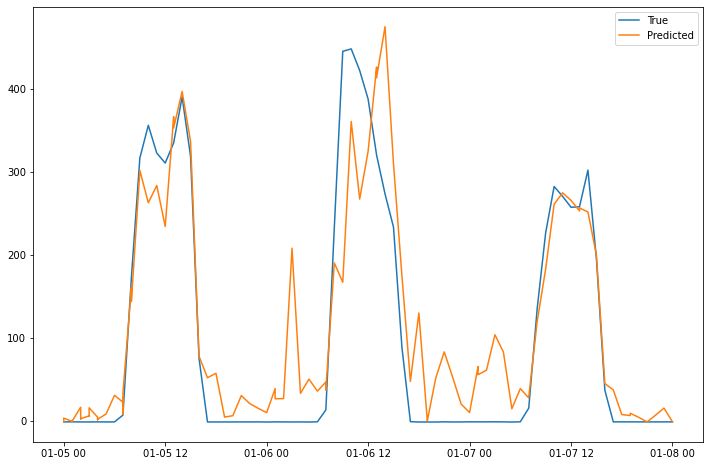

In [61]:
plt.figure(figsize=(12, 8))
plt.plot(df2.index[150:250], df2['SOUTH_solar'][150:250], label = 'True')
plt.plot(df2.index[150:250], y_pred[150:250], label = 'Predicted')
plt.legend()

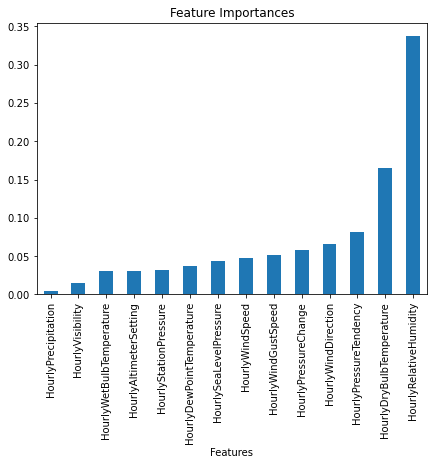

In [62]:
feature_importance_df = pd.DataFrame({'Feature Importances': tree2.feature_importances_, 'Features': X_train.columns.values})

feature_importance_df.sort_values('Feature Importances').plot.bar(x = 'Features', figsize = (7, 5), legend=False, title='Feature Importances');

In [63]:
from sklearn.linear_model import LinearRegression
lm2 = LinearRegression()
lm2.fit(X, y)
y_pred = lm2.predict(X)

In [64]:
r2_score(y, y_pred)

0.44108093172189

In [65]:
coefs = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(lm2.coef_), columns = ['EV Generation'])], axis = 1)
coefs = coefs.set_index(0)

In [66]:
coefs.sort_values('EV Generation', ascending = False)

,EV Generation
0,
HourlySeaLevelPressure,1466.288467
HourlyStationPressure,517.145862
HourlyPressureChange,240.403837
HourlyDryBulbTemperature,36.790408
HourlyWindSpeed,4.415333
HourlyDewPointTemperature,1.727126
HourlyPressureTendency,1.358938
HourlyPrecipitation,0.598243
HourlyWindGustSpeed,0.573951


# Mid-Atlantic

In [68]:
df3 = pd.merge(ev['MIDATL_solar'], baltimore, left_index=True, right_index=True)

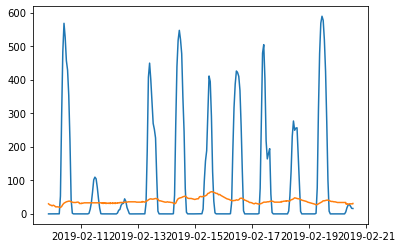

In [97]:
plt.plot(df3.index[1390:1790], df3['MIDATL_solar'][1390:1790])
plt.plot(df3.index[1390:1790], df3['HourlyDryBulbTemperature'][1390:1790])

In [75]:
for col in df3.columns:
    df3[col] = (pd.to_numeric(df3[col], errors='coerce').fillna(0))

In [76]:
X = df3.drop(['MIDATL_solar', 'HourlyPresentWeatherType', 'HourlySkyConditions'], axis=1)
y = df3['MIDATL_solar']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [77]:
tree3 = RandomForestRegressor()
tree3.fit(X_train,y_train)
score_tree3 = tree3.score(X_test,y_test)
tree_predict3 = tree3.predict(X_test)

In [78]:
r2_score(y_test, tree_predict3)

0.729495219621376

In [79]:
y_pred = tree3.predict(X)

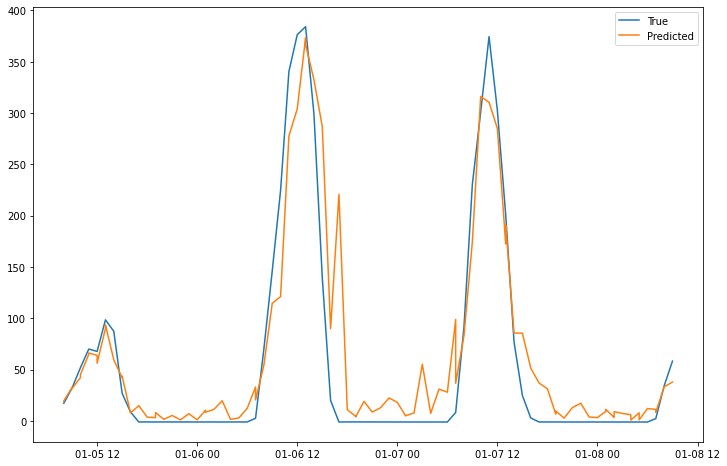

In [83]:
plt.figure(figsize=(12, 8))
plt.plot(df3.index[150:250], df3['MIDATL_solar'][150:250], label = 'True')
plt.plot(df3.index[150:250], y_pred[150:250], label = 'Predicted')
plt.legend()

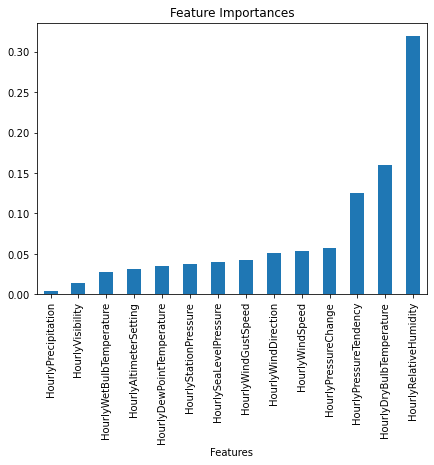

In [84]:
feature_importance_df = pd.DataFrame({'Feature Importances': tree3.feature_importances_, 'Features': X_train.columns.values})

feature_importance_df.sort_values('Feature Importances').plot.bar(x = 'Features', figsize = (7, 5), legend=False, title='Feature Importances');

In [89]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X, y)
y_pred = lm.predict(X)

In [90]:
r2_score(y, y_pred)

0.45154524762591064

In [91]:
coefs = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(lm.coef_), columns = ['EV Generation'])], axis = 1)
coefs = coefs.set_index(0)

In [92]:
coefs.sort_values('EV Generation', ascending = False)

,EV Generation
0,
HourlySeaLevelPressure,585.278502
HourlyStationPressure,322.630252
HourlyPressureChange,294.784347
HourlyPrecipitation,40.700633
HourlyDryBulbTemperature,29.073166
HourlyWindSpeed,5.467935
HourlyRelativeHumidity,1.908314
HourlyWindGustSpeed,0.833855
HourlyPressureTendency,0.762424


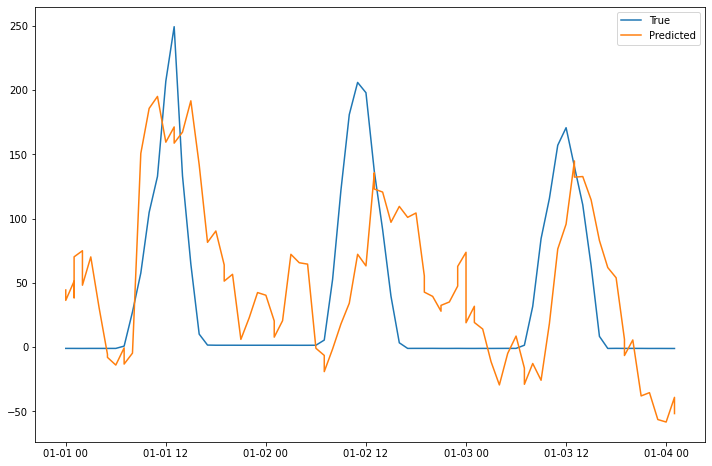

In [93]:
plt.figure(figsize=(12, 8))
plt.plot(df3.index[0:100], df3['MIDATL_solar'][0:100], label = 'True')
plt.plot(df3.index[0:100], y_pred[0:100], label = 'Predicted')
plt.legend()

# Exporting Data

## Cincinnati

In [108]:
df.to_csv('cincinnati&solar.csv');

## Richmond

In [109]:
df2.to_csv('richmond&solar.csv');

## Baltimore

In [110]:
df3.to_csv('baltimore&solar.csv');